# Continuous Control

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = UnityEnvironment(file_name='Reacher-20.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agent(s). Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agent(s). Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import torch.optim as optim
import math
from torch.utils.data import Dataset, TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:
class Q_Network(nn.Module):
    """This serves as the Q function in paper"""
    
    def __init__(self, state_size, action_size, hidden=[256, 256]):
        super(Q_Network, self).__init__()
        self.fc1 = nn.Linear(state_size+action_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.fc3 = nn.Linear(hidden[1], 1)
    
    def forward(self, states, actions):
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
MAX = 2
MIN = -10

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """This serves as both f and pi in the paper"""
    
    def __init__(self, state_size, action_size, std, hidden=[256, 256]):
        super(Actor, self).__init__()
        self.fc1_1 = nn.Linear(state_size, hidden[0])
        self.fc1_2 = nn.Linear(hidden[0], hidden[1])
        self.fc1_3 = nn.Linear(hidden[1], action_size)
        
        self.fc2_1 = nn.Linear(state_size, hidden[0])
        self.fc2_2 = nn.Linear(hidden[0], hidden[1])
        self.fc2_3 = nn.Linear(hidden[1], action_size)
        
        self.std = std
        #self.reset_parameters()
        
    def forward(self, states):
        x = F.relu(self.fc1_1(states))
        x = F.relu(self.fc1_2(x))
        means = F.tanh(self.fc1_3(x))
        
        x = F.relu(self.fc2_1(states))
        x = F.relu(self.fc2_2(x))
        #log_stds = F.hardtanh(self.fc2_3(x), MIN, MAX)
        log_stds = self.std*F.tanh(self.fc2_3(x))
        
        return means, log_stds
    
    def reset_parameters(self):
        self.fc2_1.weight.data.uniform_(*hidden_init(self.fc2_1))
        self.fc2_1.bias.data.uniform_(*hidden_init(self.fc2_1))
        self.fc2_2.weight.data.uniform_(*hidden_init(self.fc2_2))
        self.fc2_2.bias.data.uniform_(*hidden_init(self.fc2_2))

        self.fc2_3.weight.data.uniform_(-3e-3, 3e-3)
        self.fc2_3.bias.data.uniform_(-3e-3, 3e-3)

In [9]:
class Critic(nn.Module):
    """This serves as V in the paper"""
    
    def __init__(self, state_size, hidden=[256, 256]):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.fc3 = nn.Linear(hidden[1], 1)
        
    def forward(self, states):
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

In [10]:
class SAC_Agent:
    def __init__(self, env, lr=0.001, alpha=1, std=1, scale=10, learning_interval=3, tau=0.01, buffer_size=int(1e6), batch_size=128, log_in_V_loss=False, log_in_pi_loss=False):
        """
        Parameters:
        env: a gym environment
        lr: learning rate for all networks
        scale: scale for reward signals. This is to balance rewards and entropy. 
               But it's meaningless if log_in_V_loss=False, which means Q or V values are not influenced by entropy
        learning_interval: how many environment steps before a update of parameters
        tau: parameter for soft update of V
        buffer_size: the size of replaybuffer
        batch_size: how many samples to pick from replaybuffer each time
        log_in_V_loss: determine if V and Q should be influenced by entropy, original paper is True
        log_in_pi_loss: determine which kind of loss for pi, original paper is True
        """
        
        #Initialize environment
        brain_name = env.brain_names[0]
        brain = env.brains[brain_name]
        env_info = env.reset(train_mode=True)[brain_name]
        num_agents = len(env_info.agents)
        action_size = brain.vector_action_space_size
        states = env_info.vector_observations
        state_size = states.shape[1]
        self.env = env
        
        #Initialize some hyper parameters of agent
        self.lr = lr
        self.learning_interval = learning_interval
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.gamma = 0.99
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.scale = scale#the scale for reward 
        self.tau = tau#parameter for soft update of V
        self.std = std#range of std
        self.alpha = alpha#coefficent of entropy
        
        #Networks and optimizers
        #Two Q-Networks to reduce over optimistic estimate
        self.Q1 = Q_Network(self.state_size, self.action_size).to(device)
        self.Q2 = Q_Network(self.state_size, self.action_size).to(device)
        self.pi = Actor(self.state_size, self.action_size, self.std).to(device)
        #Two V-Networks to stablize training of Q-Networks
        self.V_local = Critic(self.state_size).to(device)
        self.V_target = Critic(self.state_size).to(device)
        
        self.Q1_optimizer = optim.Adam(self.Q1.parameters(),lr=self.lr)
        self.Q2_optimizer = optim.Adam(self.Q2.parameters(),lr=self.lr)
        self.pi_optimizer = optim.Adam(self.pi.parameters(),lr=self.lr)
        self.V_optimizer = optim.Adam(self.V_local.parameters(),lr=self.lr)
        
        #Replay Buffer for updating Q-Networks
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size)
        
        #Make a copy of V to the other
        self.soft_update(self.V_local, self.V_target, 1)
        
        #Choose which loss to use
        self.log_in_V_loss = log_in_V_loss
        self.log_in_pi_loss = log_in_pi_loss
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
    def act(self, states):
        with torch.no_grad():
            means, log_stds = self.pi(states)
            stds = log_stds.exp()
            actions = torch.distributions.Normal(means, stds).sample()
            actions = torch.tanh(actions)#control range
            actions = actions.detach().cpu().numpy()
        return actions
    
    def learn(self):
        states, actions, rewards, next_states, dones = self.memory.sample()#These values do not have gradients
        means, log_stds = self.pi(states)
        stds = log_stds.exp()
        original_actions = 0.5*(torch.log(1+actions+1e-7) - torch.log(1-actions+1e-7))#inverse tanh, no gradient
        noise = (original_actions-means)/stds#standardize
        noise = noise.detach()#cut off gradient here for reparametrization
        new_original_actions = means + noise*stds#with gradient
        new_actions = torch.tanh(new_original_actions)#get the same action with gradient, reparametrization
        log_probs = torch.distributions.Normal(means, stds).log_prob(new_original_actions)#not finished yet
        log_probs -= torch.log(1 - new_actions.pow(2) + 1e-7)#This gives the correct log-likelihood
        log_probs = log_probs.sum(dim=1, keepdim=True)
        
        #Update V_local
        values = self.V_local(states)
        Q1_values = self.Q1(states, actions)
        Q2_values = self.Q2(states, actions)
        Q_values = torch.min(input=Q1_values, other=Q2_values)
        #we only need the gradient of V here
        if self.log_in_V_loss:
            V_Loss = 0.5*(values - Q_values.detach() + self.alpha*log_probs.detach()).pow(2).mean()
        else:
            V_Loss = 0.5*(values - Q_values.detach()).pow(2).mean()
        self.V_optimizer.zero_grad()
        V_Loss.backward()
        self.V_optimizer.step()
        
        #Update Q_Networks(both)
        with torch.no_grad():
            next_values = self.V_target(next_states)
            expected_values = rewards + self.gamma*(1-dones)*next_values
        #Now update Q1
        Q1_Loss = 0.5*(Q1_values-expected_values).pow(2).mean()
        self.Q1_optimizer.zero_grad()
        Q1_Loss.backward()
        self.Q1_optimizer.step()
        #Now update Q2
        Q2_Loss = 0.5*(Q2_values-expected_values).pow(2).mean()
        self.Q2_optimizer.zero_grad()
        Q2_Loss.backward()
        self.Q2_optimizer.step()
        
        #Update pi and std
        Q1_values = self.Q1(states, new_actions)
        Q2_values = self.Q2(states, new_actions)#guarantees this has gradients back into pi
        Q_values = torch.min(input=Q1_values, other=Q2_values)
        if self.log_in_pi_loss:
            #The loss in original paper E[log-likelihood - Q]
            pi_loss = (self.alpha*log_probs - Q_values).mean()
        else:
            #The loss like DDPG, maximize Q, but this one also changes std part
            #should also help training (and it does)
            pi_loss = -Q_values.mean()
        self.pi_optimizer.zero_grad()
        pi_loss.backward()
        self.pi_optimizer.step()
        
        #Soft update V
        self.soft_update(self.V_local, self.V_target, self.tau)        
        
    def train(self, n_episode, max_time):
        '''
        This function do the training part of the agent. The procedure is like:
            1. initialize environment
            2. Go through a whole episode, recode all states, actions, log_probs, rewards and dones information
            3. call learn function to update the networks
            4. repeat 2-3 for n_episode times.
        '''
        all_rewards = []
        brain_name = self.env.brain_names[0]
        score_window = deque(maxlen=100)
        
        for i in range(1, n_episode+1):
            #initialize environment
            episodic_reward = np.zeros(self.num_agents)
            env_info = self.env.reset(train_mode=True)[brain_name]
            states = env_info.vector_observations
            actions = self.act(torch.tensor(states, dtype=torch.float))
            t = 0
            
            while True:
                env_info = self.env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                dones = env_info.local_done
                scores = env_info.rewards
                episodic_reward += np.array(scores)
                for state, action, score, next_state, done in zip(states, actions, scores, next_states, dones):
                    #in the following step, we give score a scale instead of giving entropy a scale as suggested in paper
                    self.memory.add(state, action, self.scale*score, next_state, done)
                
                states = next_states
                actions = self.act(torch.tensor(states, dtype=torch.float))
                t += 1
                if t % self.learning_interval == 0:
                    if len(self.memory)>self.batch_size:
                        self.learn()
            
                if any(dones) or t>max_time:
                    break
            
            score_window.append(np.mean(episodic_reward))
            all_rewards.append(episodic_reward)
            print('\rEpisode {}. Total score for this episode: {:.4f}, average score {:.4f}'.format(i, np.mean(episodic_reward), np.mean(score_window)),end='')
            if i % 100 == 0:
                print(' ')
                if np.mean(episodic_reward<1.5):
                    print('Failed to reach 1.5 after 100 episodes. Terminated')
                    break
            if np.mean(score_window)>=35:
                print('\nTraining finished! Average score reached 35 at {} episode!'.format(i))
                break
        
        #np.save('SAC_rewards.npy',np.array(all_rewards))
        #self.pi.cpu()
        #torch.save(self.pi.state_dict(),'SAC_checkpoint.pth')
        return all_rewards

## Performance of SAC with different batchsize

The following three blocks checks the performance of agent under batchsize=128, 256 and 512. Clearly larger batchsize helps training.

Episode 100. Total score for this episode: 38.9275, average score 26.3458 
Episode 124. Total score for this episode: 38.4130, average score 35.1585
Training finished! Average score reached 35 at 124 episode!


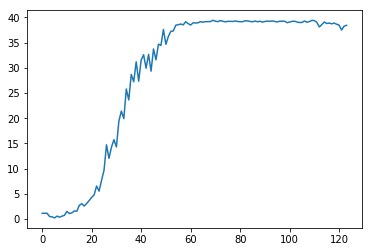

In [11]:
agent = SAC_Agent(env=env, lr=1e-3, alpha=1, std=0.5, scale=10000, learning_interval=2, tau=0.001, buffer_size=int(1e6), batch_size=128, log_in_V_loss=True, log_in_pi_loss=True)
rewards = agent.train(250, 1500)
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

Episode 100. Total score for this episode: 38.7105, average score 31.6079 
Episode 110. Total score for this episode: 38.6530, average score 35.3504
Training finished! Average score reached 35 at 110 episode!


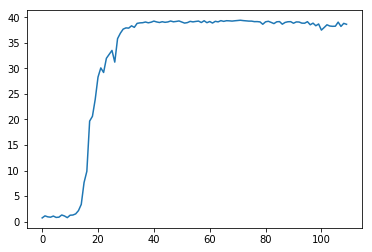

In [12]:
agent = SAC_Agent(env=env, lr=1e-3, alpha=1, std=0.5, scale=10000, learning_interval=2, tau=0.001, buffer_size=int(1e6), batch_size=256, log_in_V_loss=True, log_in_pi_loss=True)
rewards = agent.train(250, 1500)
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

Episode 100. Total score for this episode: 39.0745, average score 31.7675 
Episode 109. Total score for this episode: 38.8925, average score 35.2381
Training finished! Average score reached 35 at 109 episode!


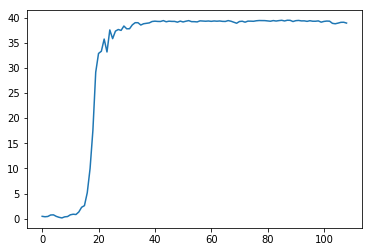

In [13]:
agent = SAC_Agent(env=env, lr=1e-3, alpha=1, std=0.5, scale=10000, learning_interval=2, tau=0.001, buffer_size=int(1e6), batch_size=512, log_in_V_loss=True, log_in_pi_loss=True)
rewards = agent.train(250, 1500)
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

## Change the scale

Now we change the scale of reward for the agent. We should know that when scale is not larger enough, the rewards will be much smaller than the entropy term and the agent will learns a policy that acts randomly. This scale is, and should be, task specific and very sensitive for the training. 

As you can see smaller scales trains slower and when it comes to 100, the training cannnot even proceed.

Episode 100. Total score for this episode: 38.8030, average score 28.9289 
Episode 117. Total score for this episode: 38.2015, average score 35.3130
Training finished! Average score reached 35 at 117 episode!


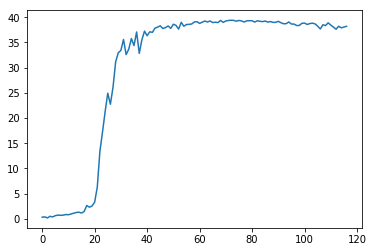

In [14]:
agent = SAC_Agent(env=env, lr=1e-3, alpha=1, std=0.5, scale=1000, learning_interval=2, tau=0.001, buffer_size=int(1e6), batch_size=512, log_in_V_loss=True, log_in_pi_loss=True)
rewards = agent.train(250, 1500)
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

Episode 100. Total score for this episode: 0.5955, average score 0.6844 
Failed to reach 1.5 after 100 episodes. Terminated


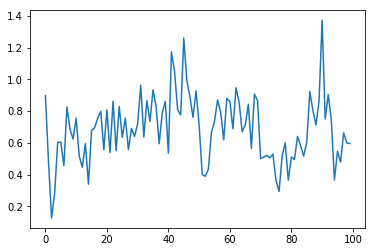

In [19]:
agent = SAC_Agent(env=env, lr=1e-3, alpha=1, std=0.5, scale=100, learning_interval=2, tau=0.001, buffer_size=int(1e6), batch_size=512, log_in_V_loss=True, log_in_pi_loss=True)
rewards = agent.train(250, 1500)
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

## Degenerate to DDPG

Now we delete entropy term in the updates of V and $\pi$ networks. This will return to a enhanced version of DDPG. Comparing the results we can see how much the entropy has helped training.

Episode 100. Total score for this episode: 0.5380, average score 0.6004 
Failed to reach 1.5 after 100 episodes. Terminated


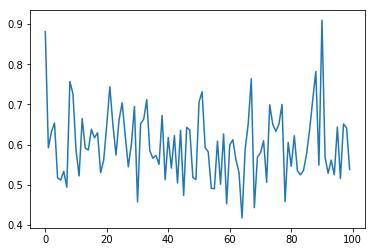

In [15]:
#This block often fails
agent = SAC_Agent(env=env, lr=1e-3, alpha=1, std=0.5, scale=10000, learning_interval=2, tau=0.001, buffer_size=int(1e6), batch_size=128, log_in_V_loss=False, log_in_pi_loss=False)
rewards = agent.train(250, 1500)
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

Episode 100. Total score for this episode: 38.8840, average score 15.4635 
Episode 157. Total score for this episode: 38.7505, average score 35.0930
Training finished! Average score reached 35 at 157 episode!


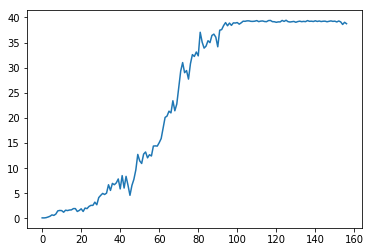

In [12]:
agent = SAC_Agent(env=env, lr=1e-3, alpha=1, std=0.5, scale=10000, learning_interval=2, tau=0.001, buffer_size=int(1e6), batch_size=256, log_in_V_loss=False, log_in_pi_loss=False)
rewards = agent.train(250, 1500)
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

Episode 100. Total score for this episode: 39.3595, average score 23.9314 
Episode 130. Total score for this episode: 38.7400, average score 35.1502
Training finished! Average score reached 35 at 130 episode!


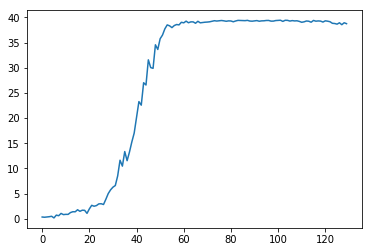

In [17]:
agent = SAC_Agent(env=env, lr=1e-3, alpha=1, std=0.5, scale=10000, learning_interval=2, tau=0.001, buffer_size=int(1e6), batch_size=512, log_in_V_loss=False, log_in_pi_loss=False)
rewards = agent.train(250, 1500)
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

## Add entropy back, encourage exploration

The following three blocks adds entropy term to the updates of V network but not $\pi$. This should somehow encourage exploration a little bit. We can see, like previous tests, larger batchsize is necessary.

Episode 100. Total score for this episode: 39.3015, average score 17.8140 
Episode 149. Total score for this episode: 37.8415, average score 35.0846
Training finished! Average score reached 35 at 149 episode!


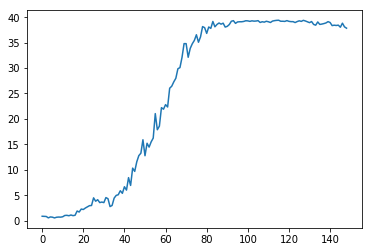

In [13]:
agent = SAC_Agent(env=env, lr=1e-3, alpha=1, std=0.5, scale=10000, learning_interval=2, tau=0.001, buffer_size=int(1e6), batch_size=128, log_in_V_loss=True, log_in_pi_loss=False)
rewards = agent.train(250, 1500)
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

Episode 100. Total score for this episode: 39.3485, average score 24.6445 
Episode 129. Total score for this episode: 38.7885, average score 35.2990
Training finished! Average score reached 35 at 129 episode!


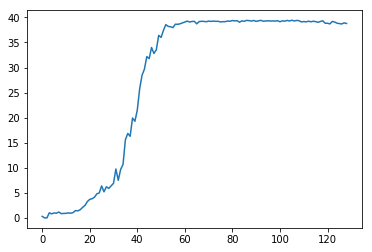

In [18]:
agent = SAC_Agent(env=env, lr=1e-3, alpha=1, std=0.5, scale=10000, learning_interval=2, tau=0.001, buffer_size=int(1e6), batch_size=256, log_in_V_loss=True, log_in_pi_loss=False)
rewards = agent.train(250, 1500)
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()

Episode 100. Total score for this episode: 39.3225, average score 27.5159 
Episode 121. Total score for this episode: 39.2770, average score 35.2797
Training finished! Average score reached 35 at 121 episode!


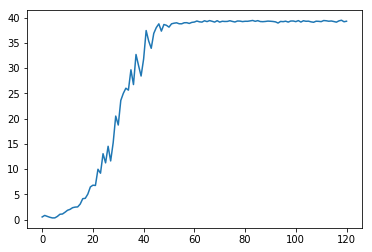

In [16]:
agent = SAC_Agent(env=env, lr=1e-3, alpha=1, std=0.5, scale=10000, learning_interval=2, tau=0.001, buffer_size=int(1e6), batch_size=512, log_in_V_loss=True, log_in_pi_loss=False)
rewards = agent.train(250, 1500)
plt.plot(np.mean(np.array(rewards),axis=1))
plt.show()